# Load packages and files

In [1]:
%matplotlib inline
import os
import boto3
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
# download files to SageMaker from S3
jcap_pickle = 'jcap_optical_encoding.pickle'
energy_npy = 'energy_ev.npy'

In [3]:
def hook(t):
  def inner(bytes_amount):
    t.update(bytes_amount)
  return inner
#session = boto3.session.Session(profile_name='hack2020')
#s3 = session.client('s3')
s3 = boto3.client('s3')
for filename in [jcap_pickle, energy_npy]:
    filesize = boto3.resource('s3').Object('hackathon2020-prod', 'data/' + filename).content_length
    with tqdm(total=filesize, unit='B', unit_scale=True, desc=jcap_pickle) as t:
        s3.download_file('hackathon2020-prod', 'data/' + filename, filename, Callback=hook(t))

jcap_optical_encoding.pickle: 100%|██████████| 154M/154M [00:01<00:00, 144MB/s]  
jcap_optical_encoding.pickle: 100%|██████████| 1.01k/1.01k [00:00<00:00, 31.3kB/s]


In [4]:
# load pickle data into dataframe
energy_ev = np.load(energy_npy)
jcap_df = pd.read_pickle(jcap_pickle)
jcap_df.shape
#jcap_df.head()
#jcap_df.columns
#jcap_df.bandgap

(100430, 45)

# Define features

In [5]:
def get_bandgap_features(dataframe):
    features = dataframe.drop(['vae','bandgap','spectrum','bandgap_pred'], axis=1, errors='ignore')
    
    return features

# Partition data into seed and candidate data

In [11]:
# Choose every other for train / test
#k_seed_data = jcap_df.iloc[::2]
#k_candidate_data = jcap_df.iloc[1::2]
#k_candidate_data.drop(['bandgap'], axis=1)

# Alternative: choose randomly
k_seed_idx = np.random.rand(len(jcap_df)) < 0.1
k_seed_data = jcap_df[k_seed_idx].copy()
k_candidate_data = jcap_df[~k_seed_idx].copy()
k_seed_data_mean = np.mean(k_seed_data['bandgap'])

In [12]:
print(len(k_seed_data)/len(k_candidate_data)*100)
print(len(k_seed_data))
print(len(k_candidate_data))

11.146771730228645
10072
90358


In [13]:
k_seed_data = k_seed_data.sort_values('bandgap',ascending=True)
k_seed_data.head(5)

,bandgap,vae,spectrum,Fe,Sn,Ti,Zn,Ce,Co,Ni,...,Ba,Yb,P,Sc,Ag,Tb,Nd,Pd,Hf,Rb
comp_id,,,,,,,,,,,,,,,,,,,,,
93109,0.901216,"[-0.012708543, 0.07445078, -0.051848263, -0.12...","[0.4623535, 0.48532963, 0.50143397, 0.511253, ...",0.1,0.0,0.0,0.0,0.0,0.2,0.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
138587,0.988739,"[-0.42450216, -0.28308696, -0.9135691, -0.4127...","[0.6643369, 0.66401064, 0.6576747, 0.6427205, ...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1,0.0
93191,1.014507,"[0.12322044, -0.03195084, 0.49643984, 0.288622...","[0.35181597, 0.35520002, 0.35712495, 0.3578851...",0.4,0.0,0.0,0.0,0.0,0.2,0.2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
85134,1.049179,"[0.18348998, 0.13217142, -0.80655944, 0.037559...","[0.61686283, 0.61940825, 0.6182576, 0.61373806...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
93120,1.078198,"[-0.095384456, -0.115211494, 0.101276524, -0.0...","[0.3933311, 0.39312688, 0.39337623, 0.39391074...",0.1,0.0,0.0,0.0,0.0,0.0,0.4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [14]:
# test to ensure no overlap between seed and candidate data
assert not set(k_seed_data.index).intersection(k_candidate_data.index)

# Define agent

In [15]:
from camd.agent.base import HypothesisAgent
from sklearn.linear_model import LinearRegression

In [17]:
class BandgapAgent(HypothesisAgent):
    def get_hypotheses(self, candidate_data, seed_data):
        # Fit on known data
        x_known = get_bandgap_features(seed_data)
        y_known = seed_data['bandgap']
        regressor = LinearRegression() # *** make changes to the regressor
        regressor.fit(x_known, y_known)
        
        # Predict unknown data
        x_unknown = get_bandgap_features(candidate_data)
        y_predicted = regressor.predict(x_unknown)
        
        # Pick top 5 candidates *** make changes to agent below for additional exploration
        # Potential changes: predict areas far from explored ones,...
        candidate_data['bandgap_pred'] = y_predicted
        candidate_data = candidate_data[candidate_data['bandgap_pred'] > 0.0]
        
        candidate_data = candidate_data.sort_values(
            'bandgap_pred', ascending=True)
        top_candidates = candidate_data.head(10000)
        return top_candidates

In [18]:
bg_agent = BandgapAgent()
hypotheses = bg_agent.get_hypotheses(k_candidate_data, k_seed_data)

In [ ]:
# see how good the predictions were
hypotheses[['bandgap','bandgap_pred']].head()

# Define experiment


In [156]:
from camd.experiment.base import ATFSampler

In [157]:
k_atf_experiment = ATFSampler(dataframe=jcap_df)

In [158]:
k_atf_experiment.submit(hypotheses)
results = k_atf_experiment.get_results()
results

,bandgap,vae,spectrum,Fe,Sn,Ti,Zn,Ce,Co,Ni,...,Ba,Yb,P,Sc,Ag,Tb,Nd,Pd,Hf,Rb
comp_id,,,,,,,,,,,,,,,,,,,,,
73947,1.714219,"[-0.11955739, -0.067887165, -0.43553743, -0.10...","[0.13661242, 0.13809696, 0.13920195, 0.1400709...",0.0,0.0,0.0,0.0,0.0,0.00,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0
178947,2.388758,"[-0.3630807, 0.2038751, -0.5046022, -0.1753244...","[0.016910221, 0.016323516, 0.015747223, 0.0154...",0.0,0.0,0.0,0.0,0.0,0.00,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0
99902,1.952089,"[-0.25971004, 0.19411993, -0.49695578, -0.0215...","[0.22904274, 0.22525191, 0.22143503, 0.2150656...",0.0,0.0,0.0,0.0,0.0,0.00,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0
74023,1.925676,"[-0.060847647, 0.02730868, -0.18535343, -0.104...","[0.10513756, 0.10672137, 0.10820968, 0.1095857...",0.0,0.0,0.0,0.0,0.0,0.00,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0
73927,1.476456,"[-0.13502865, -0.06260922, -0.4149715, -0.1513...","[0.2365516, 0.2385001, 0.2396414, 0.2396553, 0...",0.0,0.0,0.0,0.0,0.0,0.00,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61585,2.429805,"[-0.2063999, 0.07194572, -0.8310274, 0.0005266...","[0.007919694, 0.0073513417, 0.007718806, 0.008...",0.0,0.0,0.0,0.0,0.0,0.25,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0
126003,2.024728,"[0.5797147, 0.7411942, -0.87091947, 0.71492267...","[0.025477612, 0.025484541, 0.025779394, 0.0260...",0.0,0.0,0.0,0.0,0.0,0.00,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.25,0.0,0.0
967,2.129966,"[0.07758885, 0.04015165, -0.74071324, -0.01325...","[0.12177629, 0.12240852, 0.122736536, 0.123079...",0.3,0.0,0.0,0.0,0.0,0.00,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0


# Define analyzer

In [159]:
from camd.analysis import AnalyzerBase

In [160]:
class BandgapAnalyzer(AnalyzerBase):
    def analyze(self, new_experimental_results, seed_data):
        new_seed = pd.concat(
            [seed_data, new_experimental_results],
        axis=0)
        # Create a summary
        average_new_bandgap = new_experimental_results.bandgap.mean()
        average_dataset_bandgap = new_seed.bandgap.mean()
        new_result_ranks = new_seed.bandgap.rank(pct=True).loc[
            new_experimental_results.index
        ]
        min_new_bandgap = new_experimental_results.bandgap.min()
        min_dataset_bandgap = new_seed.bandgap.min()
        summary = pd.DataFrame({
            "average_new_bandgap": [average_new_bandgap],
            "average_dataset_bandgap": [average_dataset_bandgap],
            "average_rank": [new_result_ranks.mean()],
            "min_new_bandgap": [min_new_bandgap],
            "min_dataset_bandgap": [min_dataset_bandgap]
        })
        return summary, new_seed

In [161]:
k_analyzer = BandgapAnalyzer()
summary, new_seed = k_analyzer.analyze(results, k_seed_data)

In [162]:
summary

,average_new_bandgap,average_dataset_bandgap,average_rank,min_new_bandgap,min_dataset_bandgap
0,2.030628,2.172662,0.376209,0.006473,0.006473


# Define campaign

In [163]:
import os
from monty.os import cd
from camd.campaigns.base import Campaign
# Set up folders
os.system('rm -rf test')
os.system('mkdir -p test')
# Reinitialize experiment to clear history
k_atf_experiment = ATFSampler(dataframe=jcap_df)
with cd('test'):
    campaign = Campaign(
        candidate_data=k_candidate_data, 
        seed_data=k_seed_data,
        agent=bg_agent,
        experiment=k_atf_experiment,
        analyzer=k_analyzer
    )
    campaign.auto_loop(initialize=True)

Campaign initialization state: Agent BandgapAgent hypothesizing
Campaign 0 state: Running experiments
Iteration: 0
Campaign 0 state: Getting new results
Campaign 0 state: Analyzing results
Campaign 0 state: Agent BandgapAgent hypothesizing
Campaign 0 state: Running experiments
  Waiting for next round ...
Iteration: 1
Campaign 1 state: Getting new results
Campaign 1 state: Analyzing results
Campaign 1 state: Agent BandgapAgent hypothesizing
Campaign 1 state: Running experiments
  Waiting for next round ...
Iteration: 2
Campaign 2 state: Getting new results
Campaign 2 state: Analyzing results
Campaign 2 state: Agent BandgapAgent hypothesizing
Campaign 2 state: Running experiments
  Waiting for next round ...
Iteration: 3
Campaign 3 state: Getting new results
Campaign 3 state: Analyzing results
Campaign 3 state: Agent BandgapAgent hypothesizing
Campaign 3 state: Running experiments
  Waiting for next round ...
Iteration: 4
Campaign 4 state: Getting new results
Campaign 4 state: Analyzing

In [164]:
# Pull up some results
history = pd.read_pickle('test/history.pickle')

In [165]:
history

,average_new_bandgap,average_dataset_bandgap,average_rank,min_new_bandgap,min_dataset_bandgap
0,2.030628,2.172662,0.376209,0.006473,0.006473
1,2.211159,2.185517,0.516482,0.559206,0.006473
2,2.224596,2.195300,0.511756,1.004461,0.006473
3,2.300149,2.216292,0.577578,0.796731,0.006473
4,2.353898,2.239246,0.616392,0.937803,0.006473
5,2.360543,2.256587,0.608844,0.865653,0.006473
6,2.354464,2.268830,0.596695,0.759511,0.006473
7,2.460701,2.290162,0.689059,0.987485,0.006473
8,2.516947,2.312852,0.729499,0.896977,0.006473
9,2.517153,2.313835,0.737391,1.236107,0.006473


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f55a930a400>,
      dtype=object)

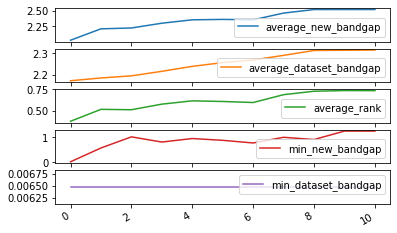

In [166]:
#visualize learning
history.plot(subplots=True)